In [3]:
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


## naver 영화 데이터

In [4]:
!head ./nsmc/ratings.txt

id	document	label
8112052	어릴때보고 지금다시봐도 재밌어요ㅋㅋ	1
8132799	디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.	1
4655635	폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.	1
9251303	와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지	1
10067386	안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.	1
2190435	사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화	1
9279041	완전 감동입니다 다시봐도 감동	1
7865729	개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음	1
7477618	굿	1


In [5]:
!head ./nsmc/ratings_train.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


## data preprocessing 예시
## : null지우기

In [ ]:
import pandas as pd

train = pd.read_csv('./nsmc/ratings_train.txt', sep='\t')
test = pd.read_csv('./nsmc/ratings_test.txt', sep='\t')

# 필요없는 열은 drop
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [7]:
print(f'trainset null 개수:\n{train.isnull().sum()}\n')
print(f'testset null 개수:\n{test.isnull().sum()}')

trainset null 개수:
document    5
label       0
dtype: int64

testset null 개수:
document    3
label       0
dtype: int64


In [8]:
train.dropna(inplace=True)
test.dropna(inplace=True)

## : 중복 제거

In [9]:
print(f'중복 제거 전 train length: {len(train)}')
train.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
print(f'중복 제거 후 train length: {len(train)}\n')
print(f'중복 제거 전 test length: {len(test)}')
test.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
print(f'중복 제거 후 test length: {len(test)}\n')

중복 제거 전 train length: 149995
중복 제거 후 train length: 146182

중복 제거 전 test length: 49997
중복 제거 후 test length: 49157



## : 정규식 사용

In [10]:
import re
from tqdm import tqdm

def removing_non_korean(df):
    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):
        new_doc = re.sub('[^가-힣]', '', row['document']).strip()
        df.loc[idx, 'document'] = new_doc
    return df

train = removing_non_korean(train)
test = removing_non_korean(test)

removing_non_korean: 100%|██████████| 49157/49157 [00:20<00:00, 2344.83it/s]


## 완료한 다음 데이터 형식

In [14]:
train.head(10)

,document,label
0,아 더 빙 진짜 짜증 나 네 요목 소리,0
1,흠 포스터 초딩 영화 줄 오버 연기 가볍 않,1
2,너무 재 밓었다그래서보는것을추천한다,0
3,교도소 이야기 구먼 솔직히 재미 없 평점 조정,0
4,사이몬페그 익살 스런 연기 돋보였 영화 스파이더맨 늙 보이 했 커스틴던스트 너무나 ...,1
5,막 걸음마 뗀 세 초등 학교 학년 생 인 살용 영화 별 반개 아까움,0
6,원작 긴장감 제대로 살려 내 못했,0
7,별반 개 아깝 욕 나온다 이응경 길용우 연기 생활 몇 년 인지 정말 발 해도 그것 ...,0
8,액션 없 재미있 몇 안 되 영화,1
9,왜 케 평점 낮 건데 꽤 볼 만 한데 헐리우드 식 화려 함 너무 길들여져 있,1


## 형태소 분석 후 불필요한 데이터 제거- mecab 사용

In [12]:
tags = ['JK', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']
#https://openuiz.tistory.com/90 참조
from konlpy.tag import Mecab

m = Mecab()

def remove_josa_mecab(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):
        josa_removed = [x[0] for x in m.pos(row['document']) if x[1] not in tags]
        df.loc[idx, 'document'] = ' '.join(josa_removed)
    return df

train_mecab = remove_josa_mecab(train, tags)
test_mecab = remove_josa_mecab(test, tags)

removing josa: 100%|██████████| 49157/49157 [00:25<00:00, 1948.54it/s]


## (komoran을 사용할 경우)

In [13]:
"""
from konlpy.tag import Komoran

k = Komoran()

def remove_josa_komoran(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):
        josa_removed = [x[0] for x in k.pos(row['document']) if x[1] not in tags]
        df.loc[idx, 'document'] = ' '.join(josa_removed)
    return df

train_komoran = remove_josa_komoran(train, tags)
test_komoran = remove_josa_komoran(test, tags)
"""

"\nfrom konlpy.tag import Komoran\n\nk = Komoran()\n\ndef remove_josa_komoran(df, tags):\n    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):\n        josa_removed = [x[0] for x in k.pos(row['document']) if x[1] not in tags]\n        df.loc[idx, 'document'] = ' '.join(josa_removed)\n    return df\n\ntrain_komoran = remove_josa_komoran(train, tags)\ntest_komoran = remove_josa_komoran(test, tags)\n"

In [15]:
train_mecab.head(10)

,document,label
0,아 더 빙 진짜 짜증 나 네 요목 소리,0
1,흠 포스터 초딩 영화 줄 오버 연기 가볍 않,1
2,너무 재 밓었다그래서보는것을추천한다,0
3,교도소 이야기 구먼 솔직히 재미 없 평점 조정,0
4,사이몬페그 익살 스런 연기 돋보였 영화 스파이더맨 늙 보이 했 커스틴던스트 너무나 ...,1
5,막 걸음마 뗀 세 초등 학교 학년 생 인 살용 영화 별 반개 아까움,0
6,원작 긴장감 제대로 살려 내 못했,0
7,별반 개 아깝 욕 나온다 이응경 길용우 연기 생활 몇 년 인지 정말 발 해도 그것 ...,0
8,액션 없 재미있 몇 안 되 영화,1
9,왜 케 평점 낮 건데 꽤 볼 만 한데 헐리우드 식 화려 함 너무 길들여져 있,1


## 클래스 분포 차이가 많이 나면 특정 클래스에 편향되서 학습하게 되므로 이를 확인해보자

/tmp/ipykernel_66879/3308272786.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


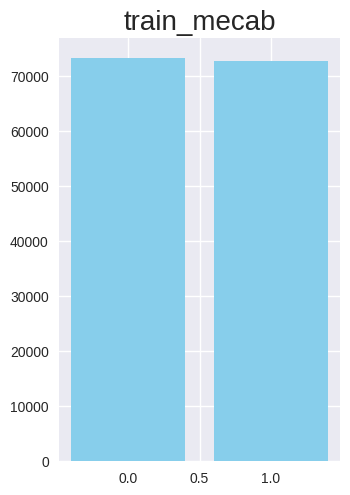

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

train_mecab_vlcnt = train_mecab['label'].value_counts().reset_index()

plt.subplot(1, 2, 1)
plt.title('train_mecab', fontsize=20)
plt.bar(train_mecab_vlcnt['index'], train_mecab_vlcnt['label'], color='skyblue')

plt.show()

In [ ]:
train_mecab.to_csv('data/train_mecab.csv', index=False)
test_mecab.to_csv('data/test_mecab.csv', index=False)